In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyBigWig as bw
import os
from scipy.stats import beta

scalar = float # a scale value (0.0 to 1.0)
def hsv_to_rgb( h:scalar, s:scalar, v:scalar) -> tuple:
    if s:
        if h == 1.0: h = 0.0
        i = int(h*6.0); f = h*6.0 - i
        
        w = v * (1.0 - s)
        q = v * (1.0 - s * f)
        t = v * (1.0 - s * (1.0 - f))
        
        if i==0: return (v, t, w)
        if i==1: return (q, v, w)
        if i==2: return (w, v, t)
        if i==3: return (w, q, v)
        if i==4: return (t, w, v)
        if i==5: return (v, w, q)
    else: return (v, v, v)

In [31]:
y = np.random.uniform(0,1,[4,12])
Ts = 4
T = 24
N = y.shape[1]

t = np.linspace(0.0, (N-1) * Ts, N)
x_fft = np.fft.fft(y)



(4, 12)

Cry1
Cry2
Nr1d1
Nr1d2
Per1
Per2
Per3
Ciart
Clock
Arntl
Npas2
Dbp
Tef
Hlf
Nfil3
Bhlhe40
Fbxl3
Csnk1e
Rora
Rorb
Rorc
Gnai2
Xkr4


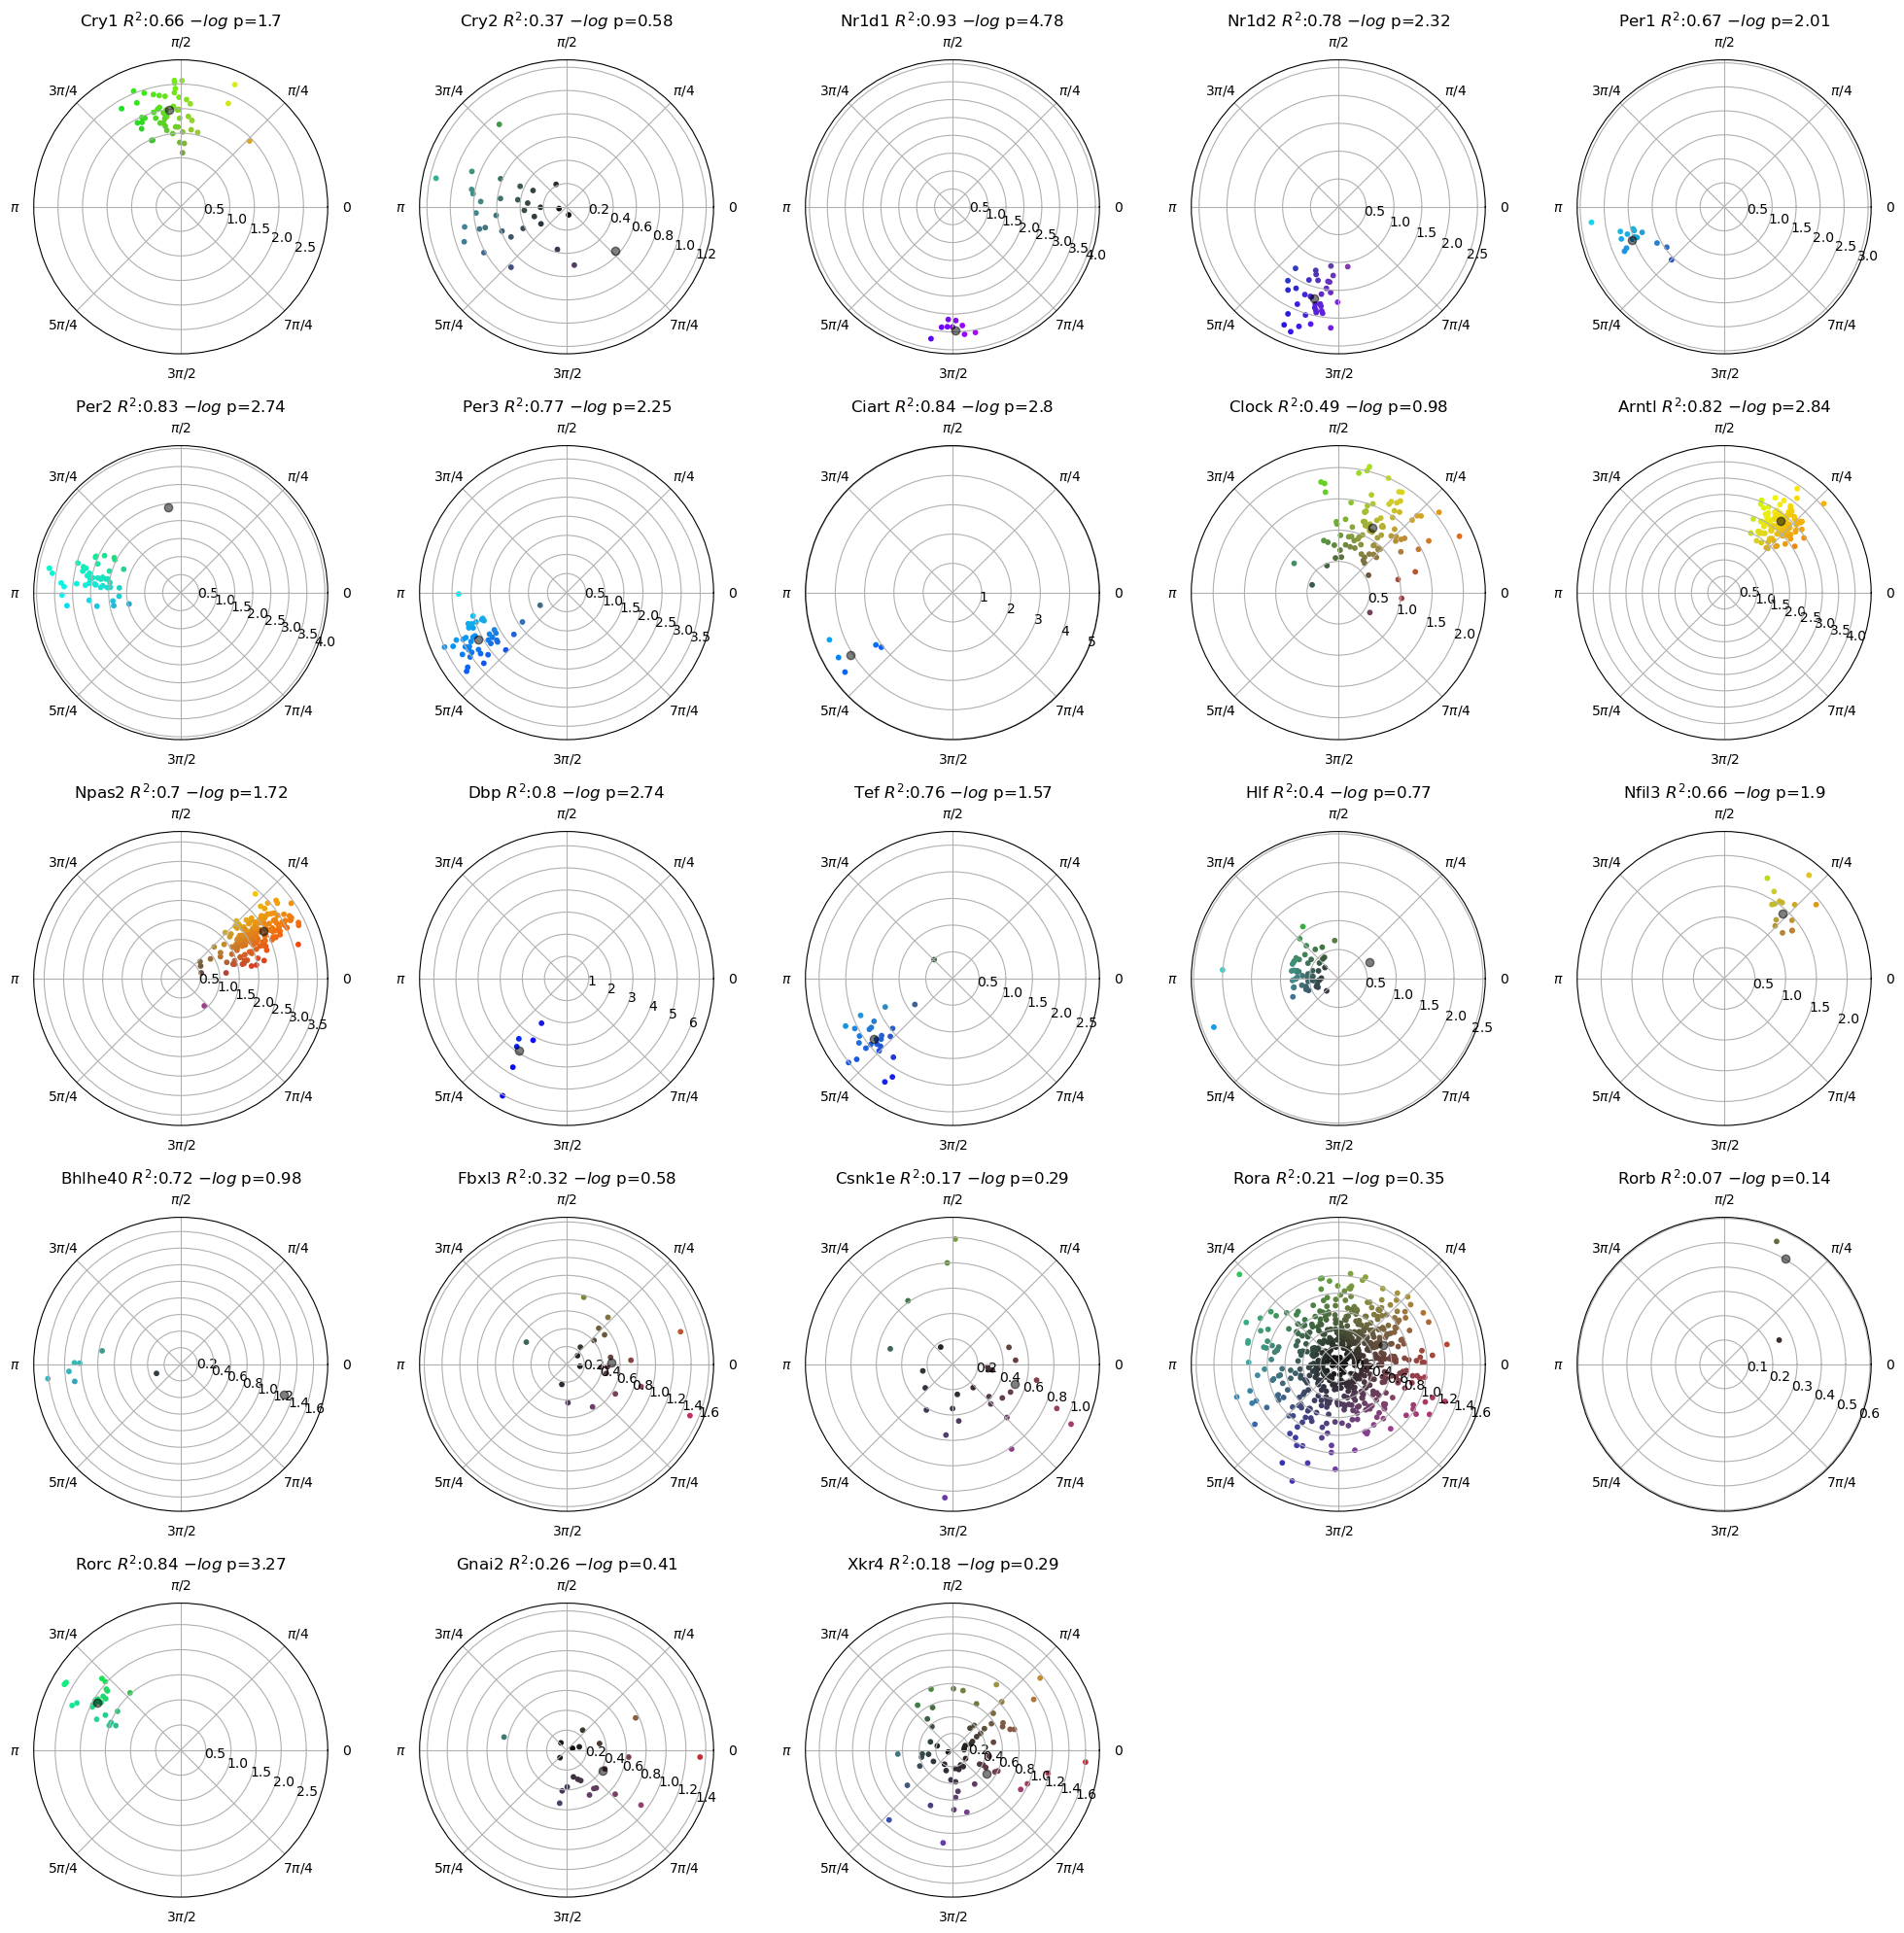

In [227]:
data_folder='../results/binned_norm_counts/'
Samples = [f'PRO_SEQ_CT{4*i:02d}_S{i+1}_R1_001' for i in range(12)]
Strands = ['forward','reverse']
bin_size = 1000
T = np.arange(0,48,4)

# awk '$3=="gene"' resources/genome/GRCm39/gencode.vM33.primary_assembly.annotation.gtf | grep "^chr" > resources/genome/GRCm39/gene.gtf
gtf = pd.read_csv('../resources/genome/GRCm39/gene.gtf',sep='\t',header=None)
gtf.columns = ['chr','source','type','start','end','score','strand','frame','attribute']
gtf['gene_name'] = gtf.attribute.str.extract(r'gene_name "(.*?)";')

f = {}
for sample in Samples:
    t = int(sample.split('_')[2][2:])
    f[t] = {}
    for strand in Strands:
        if strand=='forward':
            f[t]['+'] = bw.open(f"{data_folder}/{sample}/NormCoverage_3p_{strand}_bin{bin_size}bp.bw")
        elif strand=='reverse':
            f[t]['-'] = bw.open(f"{data_folder}/{sample}/NormCoverage_3p_{strand}_bin{bin_size}bp.bw")

Genes = ["Cry1","Cry2","Nr1d1","Nr1d2","Per1","Per2","Per3","Ciart","Clock","Arntl","Npas2","Dbp","Tef","Hlf","Nfil3","Bhlhe40","Fbxl3","Csnk1e","Rora","Rorb","Rorc","Gnai2","Xkr4"]
n_col = int(np.ceil(np.sqrt(len(Genes))))
n_row = int(np.ceil(len(Genes)/n_col))
fig = plt.figure(figsize=(n_col*4,n_row*4))
for g, gene in enumerate(Genes):
    print(gene)

    coord = gtf.loc[gtf.gene_name==gene,['chr','start','end','strand']]
    chr = coord.chr.values[0]
    start = coord.start.values[0]
    end = coord.end.values[0]
    strand = coord.strand.values[0]

    Bins = np.arange(start - start%bin_size,end + bin_size - end%bin_size,bin_size)

    X = np.zeros((len(Bins),len(T)))
    X[:] = np.nan
    df = pd.DataFrame(X,index=Bins,columns=T)

    for t in T:
        vals = f[t][strand].intervals(chr,start,end)
        if vals is None:
            df.loc[:,t] = np.nan
            continue

        bins = [vals[i][0] for i in range(len(vals))]
        counts = [vals[i][2] for i in range(len(vals))]
        df.loc[bins,t] = counts

    idx_out = np.isnan(df.values).sum(1) > .8*T.shape[0]
    df = df.loc[~idx_out,:]
    df[np.isnan(df.values)] = 0

    X = np.log(df.values + 1/bin_size)
    w = df.values.sum(1)
    w = w/w.sum()
    alpha = 0.8*(w/np.max(w)) + .1

    # fourier transform
    n = 1
    N = len(T)
    P = 24
    f_n = np.sum(X*np.exp(-1j*2*n*np.pi*T/P),1)
    a_n = 4/N * np.abs(f_n) # *4 ??
    #phi_n = np.angle(f_n)
    phi_n = np.arctan2(np.imag(f_n),np.real(f_n)) # ?? -im/re ??
    mu_n = 1/N * np.sum(X,1)

    # averaeg per gene
    #f_m = np.sum(f_n*w)
    a = np.sum(a_n*w)
    phi = np.sum(phi_n*w)
    #phi = np.arctan2(np.imag(f_m),np.real(f_m))
    #mu = 1/N * np.sum(mu_n*w)
    
    #compute the residuals and statistics of the fit (pval)
    x_hat = mu_n[:,None] + 0.5 * a_n[:,None] * np.cos(2 * np.pi / P * T[None,:] + phi_n[:,None])
    res = X - x_hat
    sig2_1 = np.var(res,1)
    sig2 = np.var(X,1)
    R2 = 1 - sig2_1 / sig2
    p = 3
    pval = 1 - beta.cdf(R2, (p - 1) / 2, (N - p) / 2)
    phi_n[phi_n<0] += np.pi * 2

    # get color
    color = len(phi_n)*[(0,0,0)]
    for i,p in enumerate(phi_n):
        # normalize phase and amplitude in [0,1]
        h = (p % (2*np.pi))/(2*np.pi)
        s = 1 - np.exp(-a_n[i])
        v = 1 - np.exp(-a_n[i])
        color[i] = hsv_to_rgb(h,s,v)

    # plot in polar coordinates
    ax = fig.add_subplot(n_row,n_col,g+1,projection='polar')
    ax.scatter(phi_n,a_n,s=10,marker='o',c=color)
    ax.plot(phi,a,'o',color='k',alpha=0.5)
    ax.set_rmax(1.1*np.max(a_n))
    ax.set_rlabel_position(-22.5)  # get radial labels away from plotted line
    ax.set_xticks(np.arange(0,2*np.pi,np.pi/4))
    ax.set_xticklabels([r'0',r'$\pi/4$',r'$\pi/2$',r'$3\pi/4$',r'$\pi$',r'$5\pi/4$',r'$3\pi/2$',r'$7\pi/4$'])
    ax.grid(True)
    ax.set_title(fr"{gene} $R^2$:{np.round(np.mean(R2),2)} $-log$ p={np.round(-np.log10(np.mean(pval)),2)}")

plt.tight_layout()
plt.savefig('../results/fig/gene_phase_amp.pdf')



In [166]:
X

b = 42
y = X[b,:]

n=1
N = len(y)
t = np.arange(0,48,4)
P = 24
f_n = np.zeros(N,dtype=complex)
for n in range(N):
    f_n[n] = np.sum(y*np.exp(-1j*2*np.pi*n/P*T))
a = 1/N*np.abs(f_n[1])
phi = np.angle(f_n[1])# * P / (2 * np.pi)

print(f_n[1])
print(np.angle(f_n[1]))
print(np.arctan2(f_n[1].imag,f_n[1].real))
print(np.arctan2(-f_n[1].imag,f_n[1].real))



t = np.linspace(0.0, (N-1) * 4, 12)
x_fft = np.fft.fft(y)
freq = np.fft.fftfreq(len(y), d=Ts)
index, = np.where(np.isclose(freq, 1/24, atol=0.005))
amp = 4 / N * np.abs(x_fft[index[0]])
phase =  np.arctan2(-x_fft[index[0]].imag, x_fft[index[0]].real) * P / (2 * np.pi)
mu = 1 / N * x_fft[0].real

print('')
print(4*a,amp)
print(mu)

(-2.9544811546823473+2.689232116419084j)
2.4031589585020683
2.4031589585020683
-2.4031589585020683

1.3317043494607037 1.3317043494607042
-3.4445173985019495


2.403158958502069

In [97]:
x_fft

array([-41.33420878+0.00000000e+00j,   0.31253297-2.02121726e-01j,
        -2.95448115+2.68923212e+00j,  -0.42167315-2.82965317e+00j,
        -2.9786095 +2.07173521e+00j,   0.10914019-1.55366194e+00j,
        -2.06165214-2.22044605e-16j,   0.10914019+1.55366194e+00j,
        -2.9786095 -2.07173521e+00j,  -0.42167315+2.82965317e+00j,
        -2.95448115-2.68923212e+00j,   0.31253297+2.02121726e-01j])